In [1]:
import pickle
import pandas as pd
from datetime import timedelta, datetime
from hs_algorithms.job_intel.job_intel_model import get_job_intel_model
from hs_algorithms.job_intel.similarity_based_measures_estimator import get_similarity_based_measurement_dynamic_params
from hs_gimme.account_settings_manager import get_account_settings
from hs_gimme.application_status_history_classifier.machine_learning_status_classifier import \
    get_machine_learning_status_classifier
from hs_gimme.db_facade.db_facade_factory import get_mongo_client_db
from collections import Counter

In [2]:


METRICS = ['num_of_apps', 
           'num_of_interview', 
           'num_of_offer']

In [3]:
data = pickle.load(open('job_intel_hack_data.pkl', 'rb'))

In [4]:
model_for_account = {}

predicted = []
for d in data:
    account_id = d['req']['account_id']
    account_settings = get_account_settings(account_id)

    if account_id not in model_for_account:
        model_for_account[account_id] = get_job_intel_model(account_id)
        
    model = model_for_account[account_id]
    req = d['req']
    
    status_cls = get_machine_learning_status_classifier('production', account_id)
    current_date = req['job_create_date'] + timedelta(days=d['days'])
    dynamic_params= get_similarity_based_measurement_dynamic_params(account_settings)
    
    phase_for_interview=None
    phase_for_offer=None

    for phase in account_settings['candidate_phases']:
        statuses = status_cls.get_statuses_in_phases([phase['id']])
        if phase_for_interview is None and 2 in set(int(t.status_bucket) for t in statuses):
            phase_for_interview = phase['id']

        if phase_for_offer is None and 3 in set(int(t.status_bucket) for t in statuses):
            phase_for_offer = phase['id']
    
    
    measures = ['num_reached_phase#APPLIED']
    measures += ['num_reached_phase#' + p for p in [phase_for_interview, phase_for_offer]]
    
    req_predicted = model.predict_measure_ranges(measures, [(req, [])], current_date, dynamic_params)

    for measure, metric in zip(measures, METRICS):
        try:
            d[f'predicted_{metric}_median'] = req_predicted[0][measure].get_value(2)
            d[f'predicted_{metric}_90s'] = req_predicted[0][measure].get_value(4)
        except:
            d[f'predicted_{metric}_median'] = None
            d[f'predicted_{metric}_90s'] = None
    
    predicted.append(d)
    

2023-06-27T13:05:13.649625Z [info     ] Loading Job Intel model...     environment=production file_path=/Users/dima/hiredscore/grading/algorithms/hs_algorithms/job_intel/job_intel_model.py function_name=get_job_intel_model hostname=Dima-Shulga-MacBook-Pro line_number=70 module=hs_algorithms.job_intel.job_intel_model pid=24118
2023-06-27T13:05:13.652007Z [info     ] Getting model reader           environment=production file_path=/Users/dima/hiredscore/brain/brainme/hs_brainme/models/model_persistence/models_persistency.py function_name=get_model_reader hostname=Dima-Shulga-MacBook-Pro line_number=82 model_key=utah model_manager=hs_algorithms model_name=job_intel model_type=pickle models_reader=LocalPickleModelsReader module=hs_brainme.models.model_persistence.models_persistency pid=24118
2023-06-27T13:05:13.652736Z [info     ] Loading model file             compressed__boolean=True dir=/Users/dima/hiredscore_model_manager/hs_algorithms/job_intel/utah_20220916030221 environment=productio

In [5]:
'Done'

'Done'

In [10]:
df = pd.DataFrame(predicted)

In [11]:
df.head()

,req_id,days,req,num_of_apps,num_of_interview,num_of_offer,predicted_num_of_apps_median,predicted_num_of_apps_90s,predicted_num_of_interview_median,predicted_num_of_interview_90s,predicted_num_of_offer_median,predicted_num_of_offer_90s
0,UNLR-04485,0,"{'_id': 'UNLR-04485', '_created_at': 2020-03-2...",6,2,0,0.0,28.4,0.0,1.0,0.0,1.0
1,UNLR-04485,1,"{'_id': 'UNLR-04485', '_created_at': 2020-03-2...",17,2,0,0.0,28.4,0.0,1.0,0.0,1.0
2,UNLR-04485,2,"{'_id': 'UNLR-04485', '_created_at': 2020-03-2...",25,2,0,0.0,40.4,0.0,1.0,0.0,1.0
3,UNLR-04485,3,"{'_id': 'UNLR-04485', '_created_at': 2020-03-2...",30,2,0,7.0,44.6,1.0,1.0,1.0,1.0
4,UNLR-04485,4,"{'_id': 'UNLR-04485', '_created_at': 2020-03-2...",35,2,0,22.0,47.6,1.0,1.0,1.0,1.0


<Axes: >

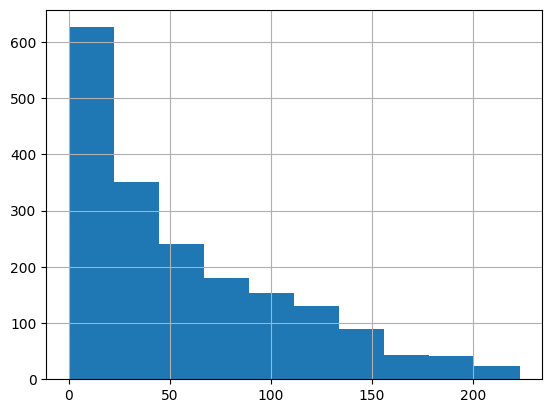

In [12]:
df['days'].hist()

In [24]:
df['weeks'] = (df['days'] / 7).round()

<Axes: >

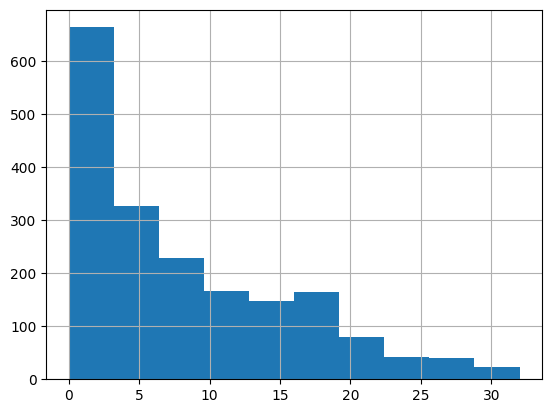

In [25]:
df['weeks'].hist()

In [15]:
df.columns

Index(['req_id', 'days', 'req', 'num_of_apps', 'num_of_interview',
       'num_of_offer', 'predicted_num_of_apps_median',
       'predicted_num_of_apps_90s', 'predicted_num_of_interview_median',
       'predicted_num_of_interview_90s', 'predicted_num_of_offer_median',
       'predicted_num_of_offer_90s', 'weeks'],
      dtype='object')

In [17]:
for f in ['num_of_apps', 'num_of_interview', 'num_of_offer']:
    for t in ['median', '90s']:
        df[f'{f}_{t}_error'] = abs(df[f] - df[f'predicted_{f}_{t}'])

In [19]:
error_fields = [f for f in df.columns if 'error' in f]
error_fields

['num_of_apps_median_error',
 'num_of_apps_90s_error',
 'num_of_interview_median_error',
 'num_of_interview_90s_error',
 'num_of_offer_median_error',
 'num_of_offer_90s_error']

In [31]:
df[error_fields].mean()

num_of_apps_median_error         108.810189
num_of_apps_90s_error             99.076375
num_of_interview_median_error      4.274572
num_of_interview_90s_error         3.256628
num_of_offer_median_error          1.155996
num_of_offer_90s_error             0.937782
dtype: float64

In [26]:
df.groupby('weeks')[error_fields].mean()

,num_of_apps_median_error,num_of_apps_90s_error,num_of_interview_median_error,num_of_interview_90s_error,num_of_offer_median_error,num_of_offer_90s_error
weeks,,,,,,
0.0,54.082192,45.561644,1.273973,1.150685,0.390411,0.486301
1.0,62.556522,54.253913,1.530435,1.547826,0.565217,0.766087
2.0,67.597561,63.895122,2.097561,2.031707,0.804878,0.812195
3.0,81.889610,75.619481,2.487013,2.240260,0.954545,0.885714
4.0,90.804348,84.142029,2.579710,2.328986,1.014493,0.733333
5.0,79.875000,84.023214,2.767857,2.351786,1.178571,0.826786
6.0,90.678571,93.917857,2.642857,2.441071,1.089286,0.769643
7.0,99.537736,103.598113,2.905660,2.475472,1.132075,0.849057
8.0,111.867347,114.365306,3.244898,2.555102,1.142857,0.879592


<Axes: >

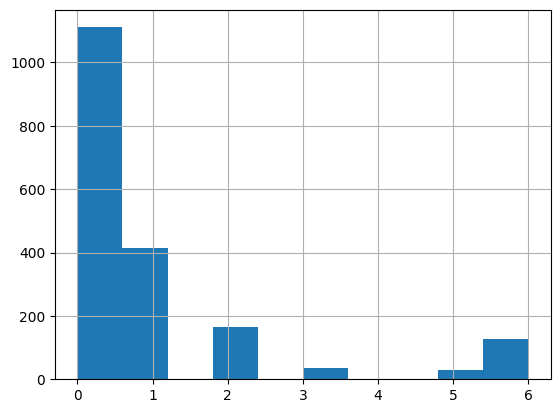

In [28]:
df['num_of_offer'].hist()

In [32]:
df[df['days'] == 0][['num_of_apps', 'predicted_num_of_apps_median', 'num_of_apps_median_error']]

,num_of_apps,predicted_num_of_apps_median,num_of_apps_median_error
0,6,0.0,6.0
30,48,NaN,NaN
31,423,41.5,381.5
41,6,4.0,2.0
106,0,NaN,NaN
180,0,0.0,0.0
194,0,2.0,2.0
321,11,NaN,NaN
326,0,NaN,NaN
342,1,0.0,1.0


In [33]:
df

,req_id,days,req,num_of_apps,num_of_interview,num_of_offer,predicted_num_of_apps_median,predicted_num_of_apps_90s,predicted_num_of_interview_median,predicted_num_of_interview_90s,predicted_num_of_offer_median,predicted_num_of_offer_90s,weeks,num_of_apps_median_error,num_of_apps_90s_error,num_of_interview_median_error,num_of_interview_90s_error,num_of_offer_median_error,num_of_offer_90s_error
0,UNLR-04485,0,"{'_id': 'UNLR-04485', '_created_at': 2020-03-2...",6,2,0,0.0,28.4,0.0,1.0,0.0,1.0,0.0,6.0,22.4,2.0,1.0,0.0,1.0
1,UNLR-04485,1,"{'_id': 'UNLR-04485', '_created_at': 2020-03-2...",17,2,0,0.0,28.4,0.0,1.0,0.0,1.0,0.0,17.0,11.4,2.0,1.0,0.0,1.0
2,UNLR-04485,2,"{'_id': 'UNLR-04485', '_created_at': 2020-03-2...",25,2,0,0.0,40.4,0.0,1.0,0.0,1.0,0.0,25.0,15.4,2.0,1.0,0.0,1.0
3,UNLR-04485,3,"{'_id': 'UNLR-04485', '_created_at': 2020-03-2...",30,2,0,7.0,44.6,1.0,1.0,1.0,1.0,0.0,23.0,14.6,1.0,1.0,1.0,1.0
4,UNLR-04485,4,"{'_id': 'UNLR-04485', '_created_at': 2020-03-2...",35,2,0,22.0,47.6,1.0,1.0,1.0,1.0,1.0,13.0,12.6,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1876,INTJR0192652,129,"{'_id': 'INTJR0192652', '_created_at': 2021-10...",23,2,0,NaN,NaN,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN
1877,INTJR0192652,130,"{'_id': 'INTJR0192652', '_created_at': 2021-10...",24,2,0,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN
1878,INTJR0192652,131,"{'_id': 'INTJR0192652', '_created_at': 2021-10...",24,2,0,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN
1879,INTJR0192652,132,"{'_id': 'INTJR0192652', '_created_at': 2021-10...",24,2,0,NaN,NaN,NaN,NaN,NaN,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN
